# glmnet example

$\,$

In [1]:
library(tidyverse)
library(sandwich)
library(gridExtra)
library(glmnet)

source("sin_basis_lib.R")

theme_update(text = element_text(size=24))
options(repr.plot.width=12, repr.plot.height=6)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr

See https://glmnet.stanford.edu/articles/glmnet.html

# Simulated example

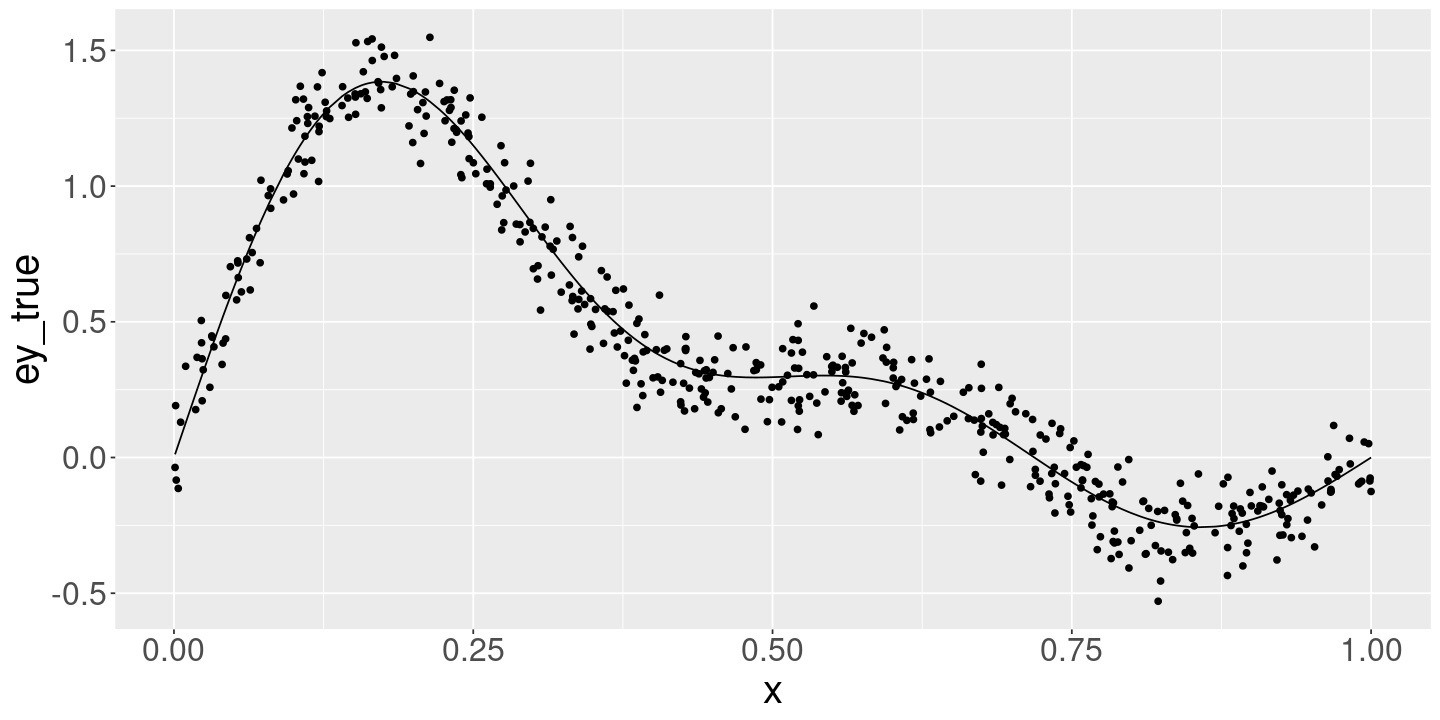

In [2]:
n_obs <- 500
sigma_true <- 0.1
pmax <- 50
p_true <- 5
beta_true <- GetBeta(p_true)

data_df <- DrawData(n_obs, sigma_true, beta_true)
test_data_df <- DrawData(n_obs, sigma_true, beta_true)

ggplot(data_df) +
    geom_line(aes(x=x, y=ey_true)) +
    geom_point(aes(x=x, y=y))

In [3]:
if (FALSE) {    
    data_norm_df <- data_df
    for (p in 1:pmax) {
        fcol <- paste0("f", p)
        data_norm_df[[fcol]] <- scale(data_norm_df[[fcol]])
        #cat(mean(data_norm_df[[fcol]]), sd(data_norm_df[[fcol]]), "\n") # sanity check
    }
}

In [16]:
x_reg_form <- paste(sprintf("f%d", 1:pmax), collapse=" + ")
reg_form <- paste0("y ~ -1 + ", x_reg_form) # glmnet includes a constant
x <- model.matrix(formula(reg_form), data_df)
y <- data_df$y

In [18]:
dim(x)

500 50

In [20]:
lm_fit <- lm(formula(paste0("y ~ ", x_reg_form)), data_df)
print(summary(lm_fit))


Call:
lm(formula = formula(paste0("y ~ ", x_reg_form)), data = data_df)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.249576 -0.070270 -0.002283  0.065265  0.256380 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -5.452e-02  3.883e-02  -1.404  0.16098    
f1           5.835e-01  4.998e-02  11.674  < 2e-16 ***
f2           6.107e-01  6.777e-03  90.112  < 2e-16 ***
f3           3.019e-01  1.788e-02  16.886  < 2e-16 ***
f4           3.341e-01  7.002e-03  47.713  < 2e-16 ***
f5           6.752e-02  1.214e-02   5.563 4.57e-08 ***
f6          -4.187e-03  6.695e-03  -0.625  0.53202    
f7           1.207e-02  9.796e-03   1.233  0.21840    
f8          -1.717e-03  6.819e-03  -0.252  0.80135    
f9           7.748e-03  8.735e-03   0.887  0.37553    
f10         -5.728e-03  6.946e-03  -0.825  0.41004    
f11          1.394e-03  8.165e-03   0.171  0.86451    
f12          1.307e-02  6.867e-03   1.904  0.05756 .  
f13         -8.012e-03  7.93

In [21]:
# Interestingly, glmnet with lambda = 0 does _not_ match lm due to differences in the 
# algorithms.  This can be made better (but not to vanish) by changing some
# of the parameters.  See, e.g.,
# https://stackoverflow.com/questions/42405362/ordinary-least-squares-with-glmnet-and-lm
for (thresh in c(1e-10, 1e-5)) {   
    ridge_fit <- glmnet(x, y, alpha=0, standardize=TRUE, lambda = rev(0:99), thres = thresh)
    beta0_ridge <- coef(ridge_fit, s=0.0, exact=TRUE) %>% as.matrix()
    beta0_lm <- coef(lm_fit)
    print(max(abs(beta0_lm - beta0_ridge)))
    #plot((beta0_ridge), (beta0_lm)); abline(0,1)
}

[1] 0.0001685906
[1] 0.05290299

In [22]:
lasso_fit <- glmnet(x, y, alpha=1, standardize=TRUE, nlambda=200)
ridge_fit <- glmnet(x, y, alpha=0, standardize=TRUE, nlambda=200)

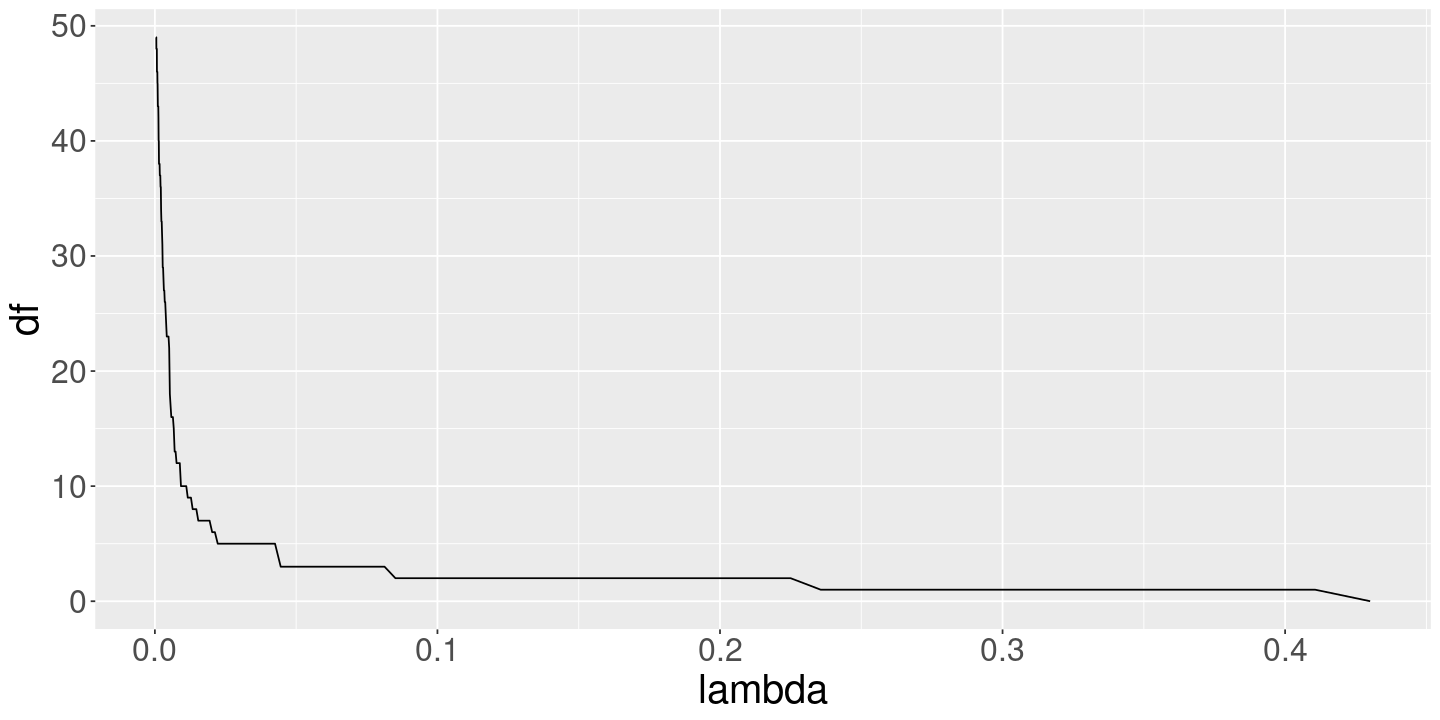

In [24]:
data.frame(lambda=lasso_fit$lambda, df=lasso_fit$df) %>%
    ggplot() + geom_line(aes(x=lambda, y=df))

In [9]:
# glmnet also supports its own cv
n_folds <- 20
lasso_cv_fit <- cv.glmnet(x, y, alpha=1, type.measure="mse", nfolds=n_folds)
ridge_cv_fit <- cv.glmnet(x, y, alpha=0, type.measure="mse", nfolds=n_folds)

In [29]:
lasso_cv_fit


Call:  cv.glmnet(x = x, y = y, type.measure = "mse", nfolds = n_folds,      alpha = 1) 

Measure: Mean-Squared Error 

      Lambda Index Measure        SE Nonzero
min 0.002830    55 0.01101 0.0004396      29
1se 0.006537    46 0.01140 0.0004224      15

In [30]:
ExtractCoefficients <- function(cv_fit) {    
    coef_df <- data.frame()
    n_lambda <- length(cv_fit$lambda)
    for (n in 1:n_lambda) {
        lambda <- cv_fit$lambda[n]
        cvm <- cv_fit$cvm[n]
        cvsd <- cv_fit$cvsd[n]
        err <- y - predict(cv_fit, s=lambda, x)
        this_coef <- 
            coef(cv_fit, s=lambda) %>% 
            as.matrix() %>% 
            as.data.frame() %>% 
            rename(beta=s1)
        this_coef$coef <- rownames(this_coef)
        this_coef$order <- 
            sub("^f", "", this_coef$coef) %>% 
            sub("\\(Intercept\\)", "-1", .) %>%
            as.numeric()
        beta <- filter(this_coef, coef != "(Intercept)") %>% pull(beta)
        l2 <- sqrt(sum(beta^2))
        this_coef <- this_coef %>% 
            mutate(lambda=lambda,
                   cvm=cvm,
                   cvsd=cvsd,
                   df=sum(abs(beta) > 1e-9),
                   l2=l2,
                   rss=mean(err^2))
        coef_df <- bind_rows(coef_df, this_coef)
    }
    return(coef_df)
}

In [31]:
coef_df <- bind_rows(
    ExtractCoefficients(lasso_cv_fit) %>% mutate(method="L1"),
    ExtractCoefficients(ridge_cv_fit) %>% mutate(method="L2")) 


In [32]:
ggplot(coef_df) +
    geom_line(aes(x=lambda, y=rss)) + scale_x_log10() +
    facet_grid(method ~ .) 

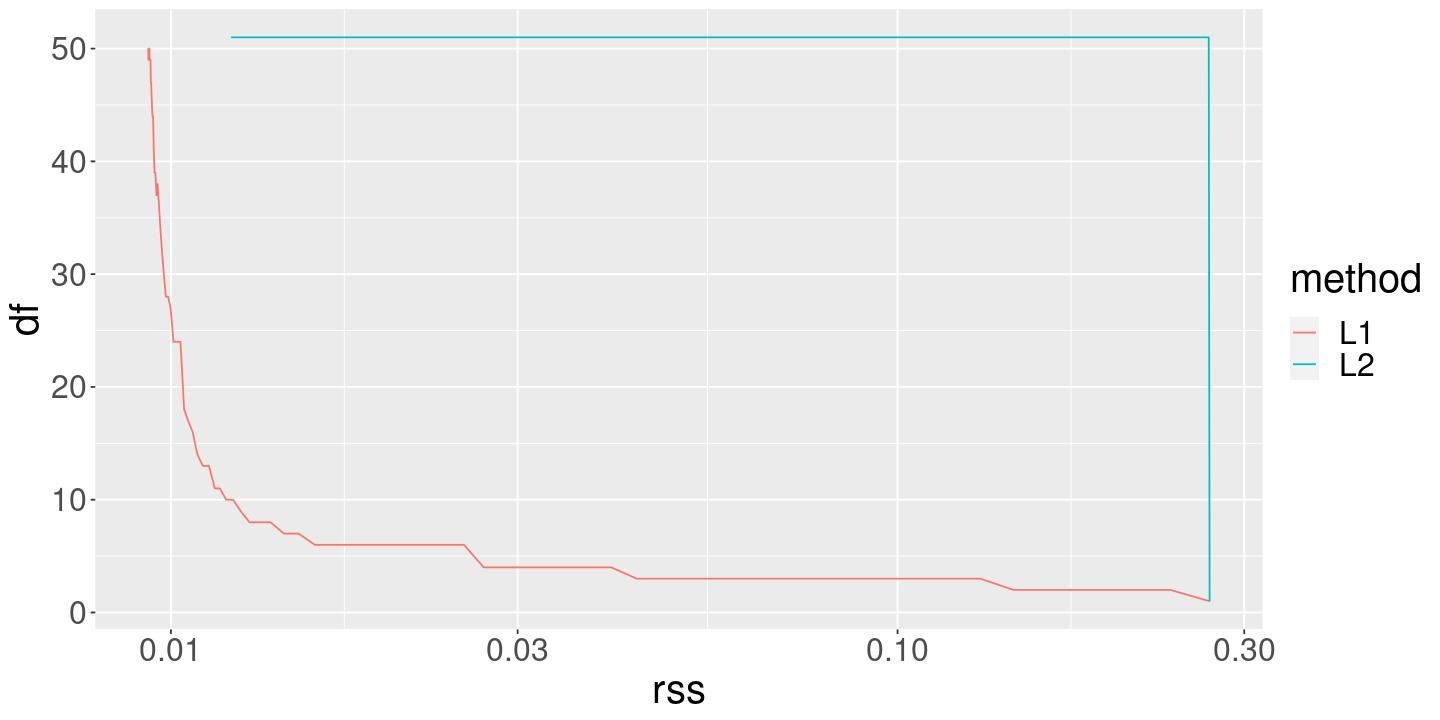

In [37]:
ggplot(coef_df) +
    geom_line(aes(x=rss, y=df, color=method)) + scale_x_log10()

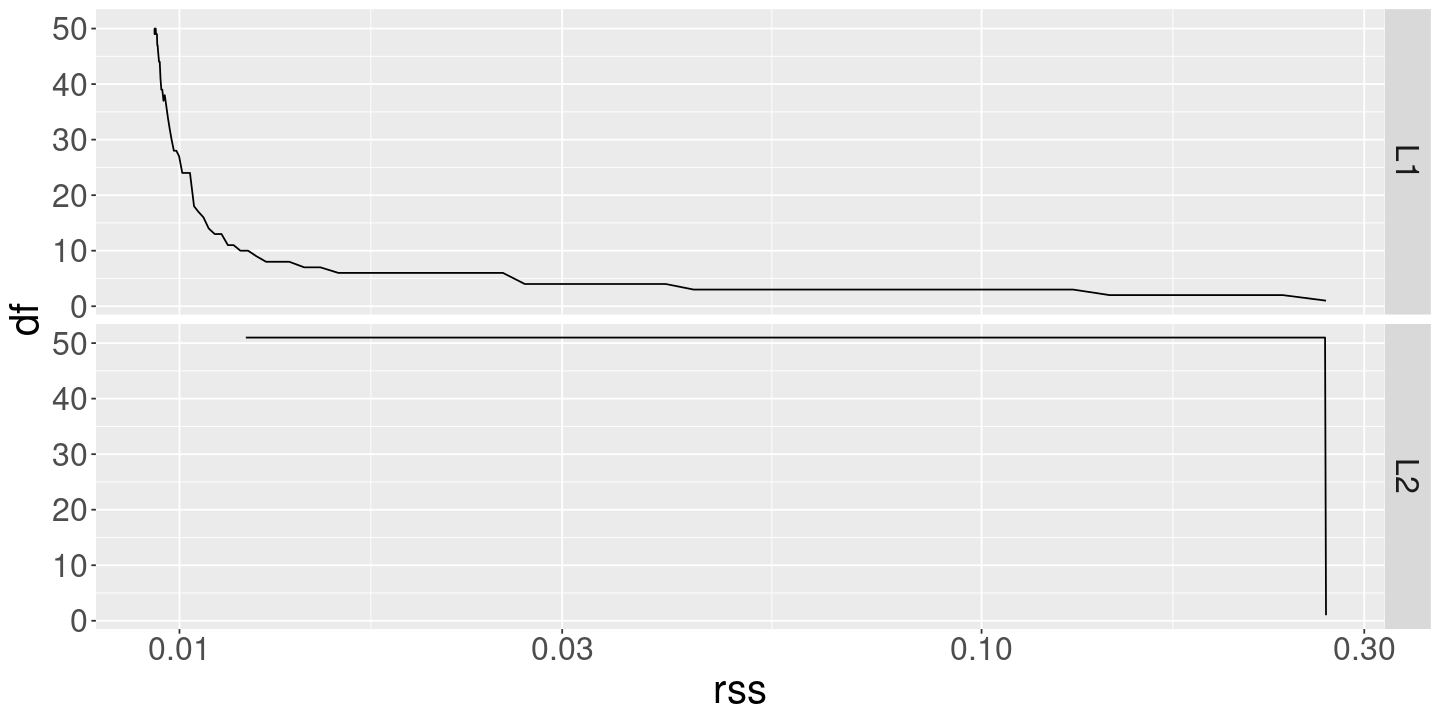

In [38]:
ggplot(coef_df) +
    geom_line(aes(x=rss, y=df)) + scale_x_log10() +
    facet_grid(method ~ .) 

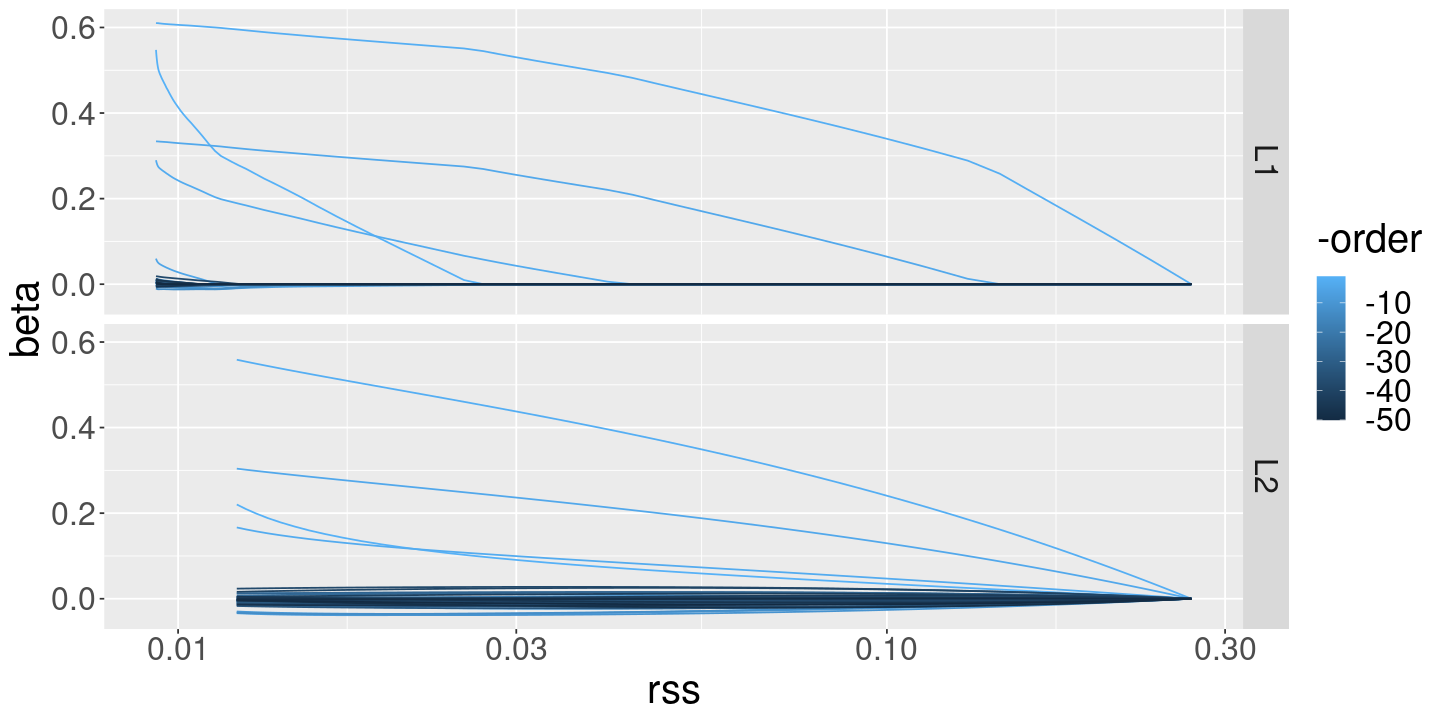

In [13]:
coef_df %>% filter(order >= 0) %>% 
    ggplot() +
        geom_line(aes(x=rss, y=beta, color=-order, group=order)) + scale_x_log10() +
        facet_grid(method ~ .) 

In [14]:
lasso_cv_fit$lambda.1se

0.006537128498188

In [15]:
beta_l1 <- coef(lasso_cv_fit, s=lasso_cv_fit$lambda.min)
beta_l2 <- coef(ridge_cv_fit, s=ridge_cv_fit$lambda.min)

beta_l1_se <- coef(lasso_cv_fit, s=lasso_cv_fit$lambda.1se)
beta_l2_se <- coef(ridge_cv_fit, s=ridge_cv_fit$lambda.1se)

cbind(beta_l1, beta_l1_se, beta_l2, beta_l2_se, c(0, beta_true))

51 x 5 sparse Matrix of class "dgCMatrix"
                       s1            s1            s1            s1           
(Intercept)  0.0559159777  0.1195199729  2.274848e-01  0.2359224816 .         
f1           0.4390850048  0.3549208581  2.202358e-01  0.2093368096 0.52255942
f2           0.6071953671  0.6028141264  5.585676e-01  0.5539988948 0.61988711
f3           0.2516674356  0.2200522237  1.665492e-01  0.1619257511 0.27967852
f4           0.3311543933  0.3259580661  3.040330e-01  0.3014332035 0.32116975
f5           0.0340254660  0.0132972595 -5.281719e-03 -0.0072554466 0.05309871
f6           .             .            -6.945189e-03 -0.0072095864 .         
f7          -0.0026578868 -0.0085139392 -3.385000e-02 -0.0347903307 .         
f8           .             .            -1.606844e-03 -0.0016509153 .         
f9          -0.0012529750 -0.0034423242 -2.983410e-02 -0.0307354498 .         
f10         -0.0015155504  .            -1.187068e-03 -0.0008688021 .         
f11       